# Final Project
##### By: Thomas Nash & Daniel Mehta

### Problem Statement:
A comparative analysis of value and performance between two Airbnb rental types across the five boroughs of New York City.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
df = pd.read_csv("Airbnb_Open_Data_cleansed.csv")

/var/folders/xb/2tg9ddl94wl284px7ngj8hn40000gn/T/ipykernel_25259/1262225521.py:1: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Airbnb_Open_Data_cleansed.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102599 non-null  object 
 10  country code                    102599 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

## Cleaning and Preprocessng

In [5]:
df_clean = df.copy()
df_vis = df.copy()

In [6]:
#Dropping Unneeded Columns
columns_to_drop = [
    'id', 'NAME', 'host id', 'host name', 'country', 'country code',
    'last review', 'house_rules', 'license', 'lat', 'long'
]
df_clean.drop(columns=columns_to_drop, inplace=True)

In [7]:
#Drop Columns where price column is missing
df_clean = df_clean[df_clean['price'].notnull()]

In [8]:
#Remove $ and commas from price and service fee columns then convert to float
df_clean['price'] = df_clean['price'].replace('[\$,]', '', regex=True).astype(float)
df_clean['service fee'] = df_clean['service fee'].replace('[\$,]', '', regex=True).astype(float)

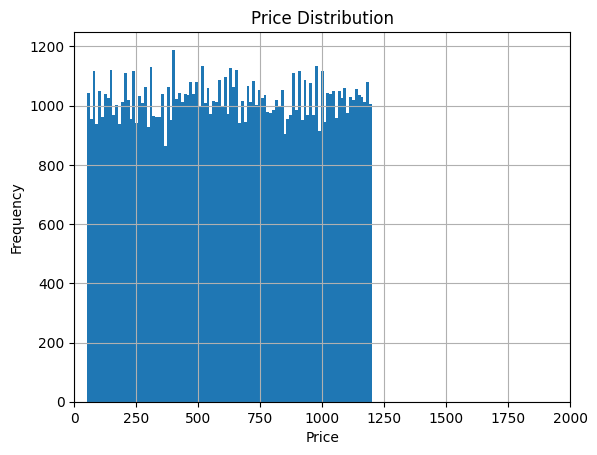

In [9]:
#Used this graph to determine if there is any unrealistic prices in the dataset, I came into the conclution that all the prices are realistic
df_clean['price'].hist(bins=100)
plt.xlim(0, 2000)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [10]:
#Dropping rows with missing values in important columns
df_clean = df_clean.dropna(subset=[
    'neighbourhood group', 'host_identity_verified', 'instant_bookable',
    'cancellation_policy', 'room type', 'Construction year',
    'minimum nights', 'number of reviews', 'reviews per month',
    'review rate number', 'calculated host listings count',
    'availability 365'
])

In [11]:
#Encode categorical features using get_dummies (one-hot encoding)
categorical_cols = [
    'neighbourhood group', 'host_identity_verified', 'instant_bookable',
    'cancellation_policy', 'room type'
]
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

In [12]:
#Feature engineering (Adding Total Cost and price per night)
df_encoded['total cost'] = df_encoded['price'] + df_encoded['service fee']
df_encoded['price_per_night'] = df_encoded['price'] / df_encoded['minimum nights']
df_encoded['price_per_night'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_encoded['price_per_night'].fillna(0, inplace=True)

In [13]:
#Resting the index
df_encoded.reset_index(drop=True, inplace=True)

In [14]:
print("Final shape:", df_encoded.shape)
df_encoded.head()

Final shape: (85029, 23)


neighbourhood  Construction year  price  service fee  minimum nights  \
0     Kingsbridge             2009.0   55.0         11.0            30.0   
1        Woodlawn             2010.0  811.0        162.0             1.0   
2  Spuyten Duyvil             2016.0  344.0         69.0             2.0   
3        Longwood             2022.0  719.0        144.0             5.0   
4       Concourse             2006.0  665.0        133.0             3.0   

   number of reviews  reviews per month  review rate number  \
0                4.0               0.35                 5.0   
1              197.0               2.49                 5.0   
2               47.0               1.22                 1.0   
3               82.0               0.96                 3.0   
4              119.0               1.41                 1.0   

   calculated host listings count  availability 365  ...  \
0                             2.0             315.0  ...   
1                             1.0             132.0  ...   
2                             1.0              28.0  ...   
3                             1.0             268.0  ...   
4                             1.0              70.0  ...   

   neighbourhood group_Staten Island  host_identity_verified_verified  \
0                              False                             True   
1                              False                            False   
2                              False                            False   
3                              False                             True   
4                              False                             True   

   instant_bookable_True  cancellation_policy_moderate  \
0                  False                         False   
1                   True                          True   
2                   True                          True   
3                  False                          True   
4                  False                         False   

   cancellation_policy_strict  room type_Hotel room  room type_Private room  \
0                        True                 False                   False   
1                       False                 False                   False   
2                       False                 False                   False   
3                       False                 False                   False   
4                        True                 False                   False   

   room type_Shared room  total cost  price_per_night  
0                  False        66.0         1.833333  
1                  False       973.0       811.000000  
2                  False       413.0       172.000000  
3                  False       863.0       143.800000  
4                  False       798.0       221.666667  

[5 rows x 23 columns]

## Data Vis

In [15]:
df_vis['price'] = df_vis['price'].replace('[\$,]', '', regex=True).astype(float)
df_vis['service fee'] = df_vis['service fee'].replace('[\$,]', '', regex=True).astype(float)

df_vis['total cost'] = df_vis['price'] + df_vis['service fee']

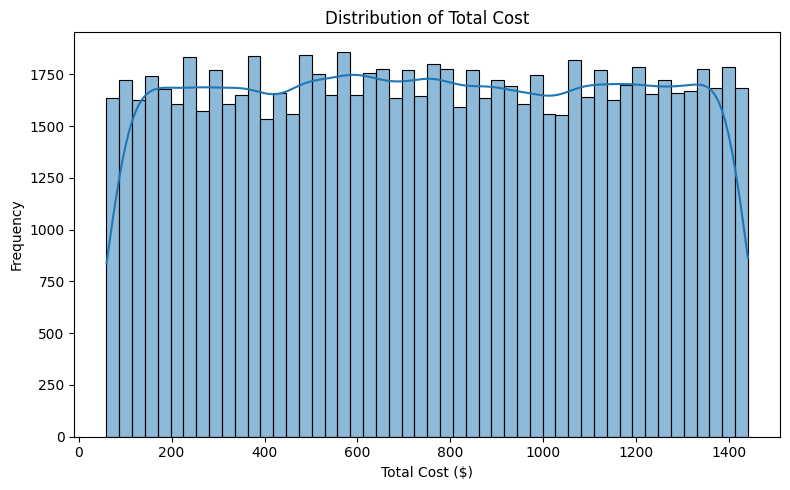

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df_encoded['total cost'], bins=50, kde=True)
plt.title("Distribution of Total Cost")
plt.xlabel("Total Cost ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

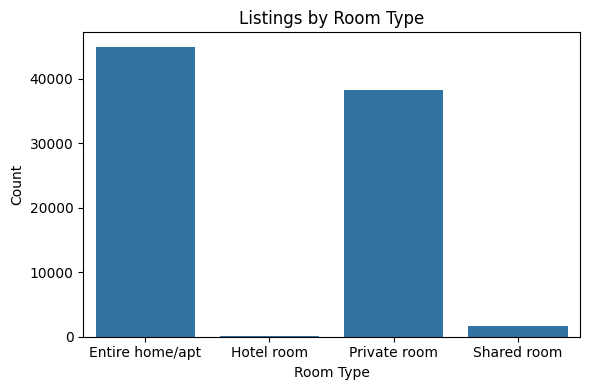

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='room type')
plt.title("Listings by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


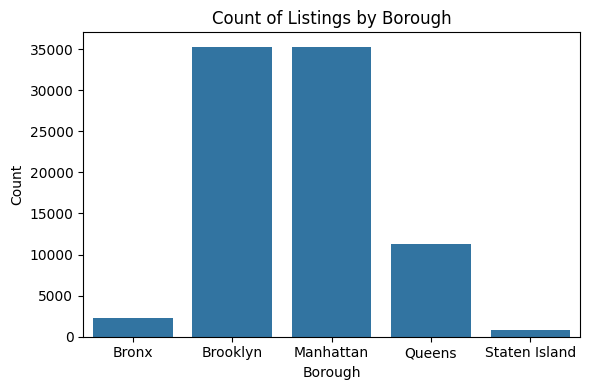

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='neighbourhood group')
plt.title("Count of Listings by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

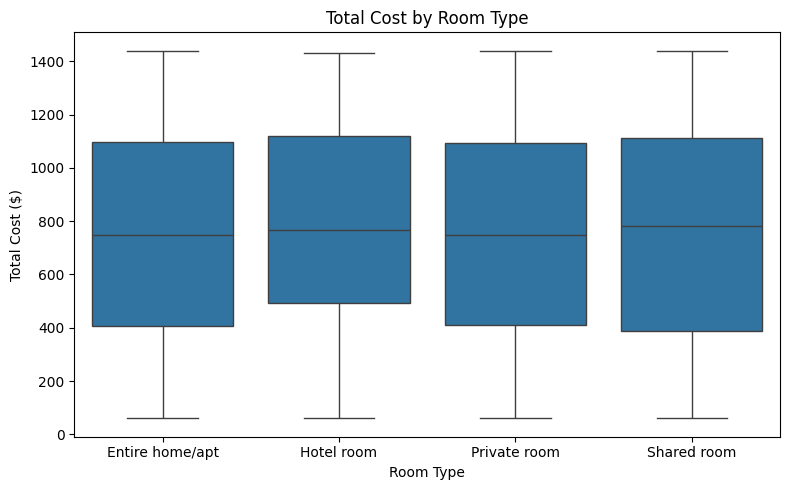

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_vis, x='room type', y='total cost')
plt.title("Total Cost by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Total Cost ($)")
plt.tight_layout()
plt.show()

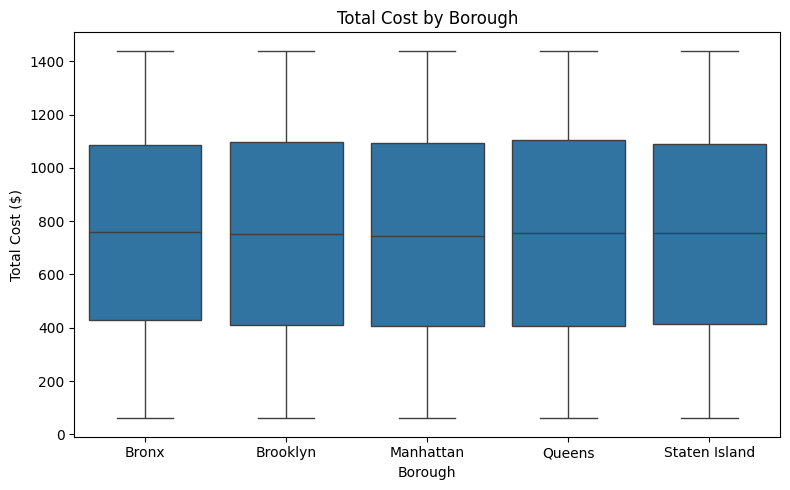

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_vis, x='neighbourhood group', y='total cost')
plt.title("Total Cost by Borough")
plt.xlabel("Borough")
plt.ylabel("Total Cost ($)")
plt.tight_layout()
plt.show()

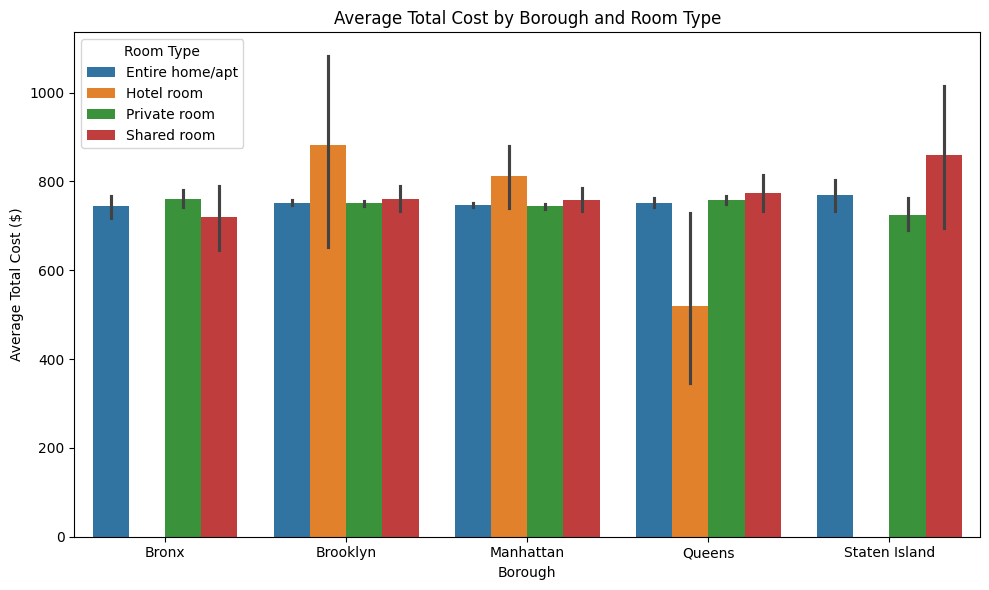

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_vis, x='neighbourhood group', y='total cost', hue='room type', estimator=np.mean)
plt.title("Average Total Cost by Borough and Room Type")
plt.xlabel("Borough")
plt.ylabel("Average Total Cost ($)")
plt.legend(title="Room Type")
plt.tight_layout()
plt.show()

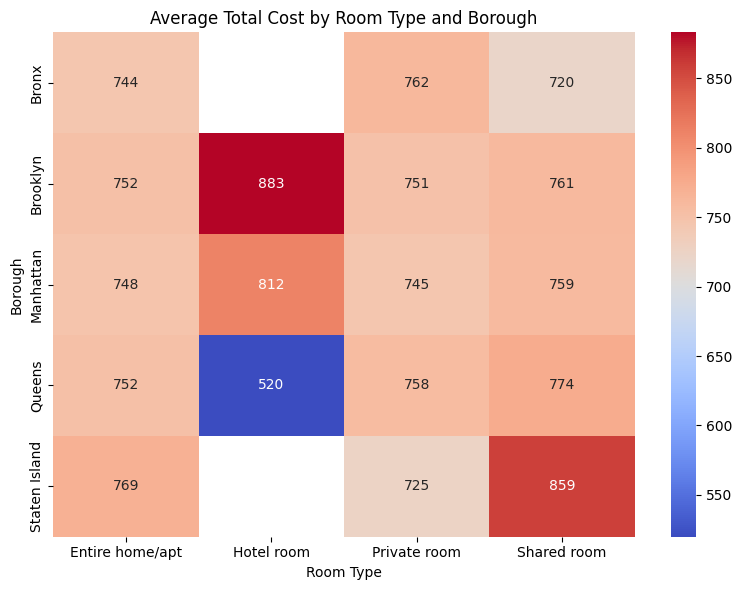

In [22]:
heatmap_data = df_vis.groupby(['neighbourhood group', 'room type'])['total cost'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Average Total Cost by Room Type and Borough")
plt.xlabel("Room Type")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()

## Model (ExtraTreesRegressor)

In [23]:
# Data Splitting

X = df_encoded.drop(columns=['price', 'service fee', 'total cost', 'price_per_night'])
y = df_encoded['total cost']
X = X.select_dtypes(include=[np.number])

# Combine and drop rows with any NaNs
model_data = pd.concat([X, y], axis=1).dropna()

# Resplit X and y after dropping NaNs
X = model_data.drop(columns=['total cost'])
y = model_data['total cost']

#80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
'''
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
'''
model = ExtraTreesRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

#train
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

In [26]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

MAE: $200.22
RMSE: $311.63
R2 Score: 0.3839


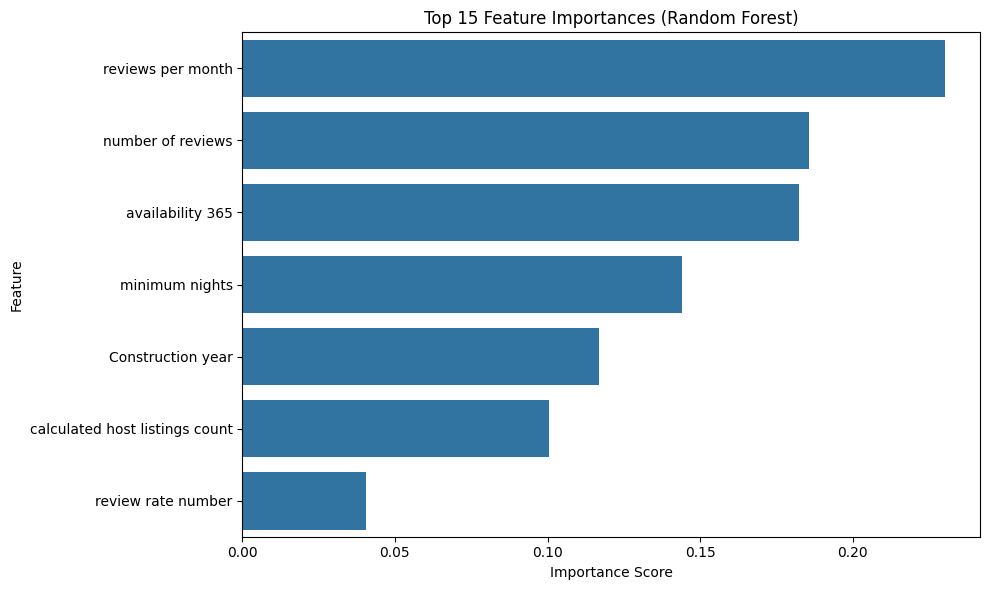

In [27]:
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:15], y=features[indices][:15])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

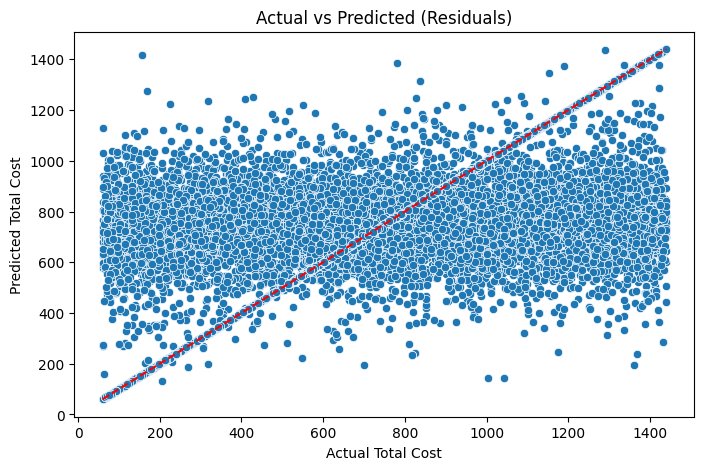

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted (Residuals)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.show()

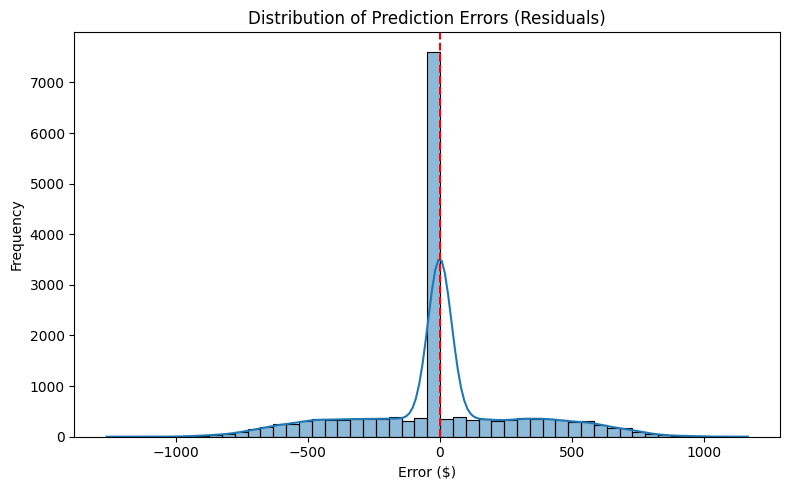

In [29]:
errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error ($)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

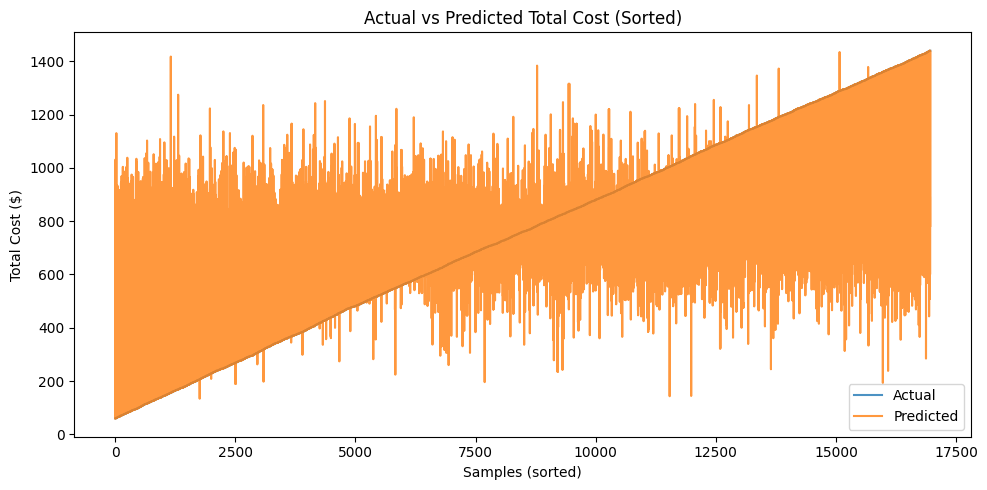

In [30]:
plt.figure(figsize=(10, 5))
sorted_idx = np.argsort(y_test.values)
plt.plot(y_test.values[sorted_idx], label='Actual', alpha=0.8)
plt.plot(y_pred[sorted_idx], label='Predicted', alpha=0.8)
plt.title("Actual vs Predicted Total Cost (Sorted)")
plt.xlabel("Samples (sorted)")
plt.ylabel("Total Cost ($)")
plt.legend()
plt.tight_layout()
plt.show()

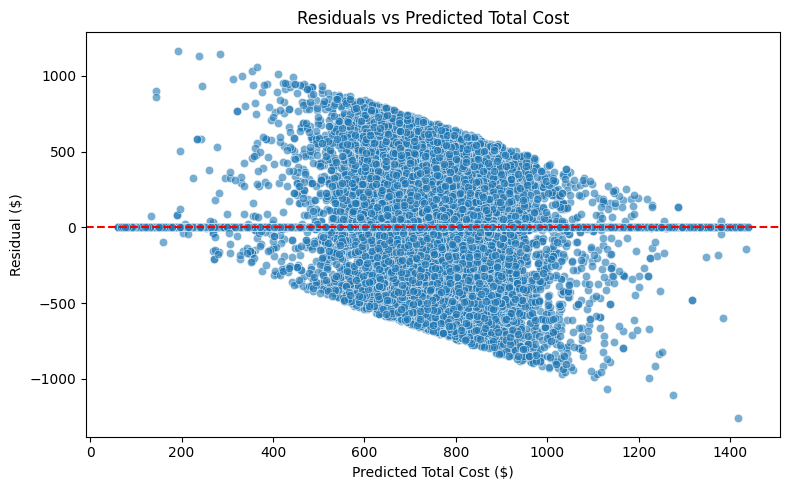

In [31]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Total Cost")
plt.xlabel("Predicted Total Cost ($)")
plt.ylabel("Residual ($)")
plt.tight_layout()
plt.show()

## Results
I compared multiple models including Linear Regression, XGBoost, Random Forest, and ExtraTrees. ExtraTrees performed the best

### Strengths
- Model performs well overall – it captures general patterns in total cost across listings
- Prediction errors are centered around 0 with no major bias in over or under-prediction
- Most predictions are accurate within $200

### Weaknesses
- Model struggles with very expensive listings – tends to underpredict the high end
- Guest activity features (reviews, availability) are more important than location
- Some predictions are too "average" – doesn’t always capture extreme cases